In [110]:
# System
import os
import yaml
import datetime

# Data Analysis
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Machine Learning
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [111]:
class Preprocessor(object):
    """
    """
    
    def __init__(self,target):
        cwd = os.getcwd()
        kaggle = os.path.join(cwd,'kaggle')
        
        self.target = target
        self.train_df = pd.read_csv(os.path.join(kaggle,'train.csv'),header=0,index_col=0).rename({self.target:'Target'},axis=1)
        self.test_df = pd.read_csv(os.path.join(kaggle,'test.csv'),header=0,index_col=0)
        
        with open(os.path.join(os.getcwd(),'features.yml'),'r') as file:
            self.features_yml = yaml.load(file, Loader=yaml.FullLoader)
        self.features = None
        self._get_features()
        
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        
        self.train_dummies = None
        self.test_dummies = None
        self.dummies = None
        
        self.scaler = None
        self.train_normalized = None
        self.test_normalized = None
        
        self.train_combined = None
        self.test_combined = None
        
        self.selector = None
        self.estimator= None
        self.selected_features = None
        self.train_selected = None
        self.test_selected = None
        
        self.X_fit = None
        self.y_fit = None
        self.X_score = None
        self.y_score = None
        self.X_pred = None
        self.y_pred = None
        
        self._clean()
        self._dummy()
        self._normalize()
        self._combine()
                    
    def _get_features(self):
        features = {'all':[]}
        for feature,info in self.features_yml.items():
            features['all'].append(feature)
            if not features.get(info['dtype'],None):
                features[info['dtype']] = []
            features[info['dtype']].append(feature)
        self.features = features
    
    def _clean(self):
        self.y_train = self.train_df.Target
        self.X_train = self.train_df.fillna(0).drop(self.features['target'],axis=1)
        self.X_test = self.test_df.fillna(0)
        
    def _dummy(self):
        self.train_dummies = pd.get_dummies(self.X_train[self.features['cat']])
        self.test_dummies = pd.get_dummies(self.X_test[self.features['cat']])
        self.dummies = list(set(list(self.train_dummies.columns)+list(self.test_dummies.columns)))
        
        for column in self.dummies:
            if column not in self.train_dummies:
                self.train_dummies[column] = 0
            if column not in self.test_dummies:
                self.test_dummies[column] = 0
        
        self.train_dummies = self.train_dummies[self.dummies]
        self.test_dummies = self.test_dummies[self.dummies]
    
    def _normalize(self):
        self.scaler = StandardScaler()
        self.scaler.fit(self.X_train[self.features['int']])
        self.scaler.fit(self.X_test[self.features['int']])
        
        self.train_normalized = pd.DataFrame(
            self.scaler.transform(self.X_train[self.features['int']])
            ,columns=self.features['int'],index=self.X_train.index
        )
        self.test_normalized = pd.DataFrame(
            self.scaler.transform(self.X_test[self.features['int']])
            ,columns=self.features['int'],index=self.X_test.index
        )
    
    def _combine(self):
        self.train_combined = self.train_dummies.join(self.train_normalized,how='inner')
        self.test_combined = self.test_dummies.join(self.test_normalized,how='inner')
    
    def select(self,num_columns=120):
        self.estimator = SVR(kernel='linear')
        self.selector = RFE(self.estimator, n_features_to_select=num_columns, step=1)
        self.selector.fit(self.train_combined,self.y_train)
        self.selected_features = self.selector.get_feature_names_out(self.selector.feature_names_in_)
        
        self.train_selected = self.train_combined[self.selected_features]
        self.test_selected = self.test_combined[self.selected_features]
        
    def split(self):
        (self.X_fit,self.X_score,
        self.y_fit,self.y_score) = train_test_split(
            self.train_selected,self.y_train,
            test_size=0.2,random_state=42
        )
        self.X_pred = self.test_selected
    
    def audit(self):
        None

In [118]:
class Model(object):
    """
    """
    def __init__(self,model_type,X_fit,y_fit,X_score,y_score,X_pred):
        self.model_type = model_type
        
        if self.model_type == 'gbr':
            self.model = GradientBoostingRegressor()
            self.parameters = {
                'n_estimators': [500*i for i in range(1,8)],
                'max_depth': [2+i for i in range(20)],
                'min_samples_split': [3+i for i in range(8)],
                'learning_rate': [0.1*i for i in range(1,30)],
                'loss': ['squared_error','absolute_error','huber','quantile'],
                'criterion': ['friedman_mse','squared_error','mse','mae'],
            }
        elif self.model_type == 'knn':
            self.model = KNeighborsRegressor()
            self.parameters = {
                'n_neighbors': [1+i for i in range(50)],
                'weights': ['uniform','distance'],
                'algorithm': ['auto','ball_tree','kd_tree'],
                'leaf_size': [10+i for i in range(40)],
                'p': [1,2],
                'metric': ['minkowski'],
            }
        elif self.model_type == 'ridge':
            self.model = Ridge()
            self.parameters = {
                'alpha': [0.1*i for i in range(1,50)],
                'solver': ['auto']
            }
        else:
            raise Exception('Unknown model type')
        
        self.X_fit = X_fit
        self.y_fit = y_fit
        self.X_score = X_score
        self.y_score = y_score
        self.X_pred = X_pred
        self.y_pred = None
        
        self.grid = None
        self.corr = None
        self.mse = None
        
        self.final = None
        self.prediction = None
    
    def tune(self):
        self.grid = GridSearchCV(self.model,self.parameters)
        self.grid.fit(X=self.X_fit,y=self.y_fit)
        self.corr = round(self.grid.score(X=self.X_score,y=self.y_score),4)
        self.mse = round(mean_squared_error(self.y_score, self.grid.predict(self.X_score)),4)

    def predict(self):
        self.output = pd.DataFrame(
            self.final.predict(self.X_pred),
            columns=['SalePrice'],index=self.X_pred.index
        )

    def refresh(self,X_fit,y_fit,X_score,y_score):
        self.X_fit = X_fit
        self.y_fit = y_fit
        self.X_score = X_score
        self.y_score = y_score
    
    def audit(self):
        None

In [117]:
preprocessor = Preprocessor(target='SalePrice')
preprocessor.select(num_columns=120)
preprocessor.split()

In [ ]:
data = {
    'X_fit': preprocessor.X_fit,
    'y_fit': preprocessor.y_fit,
    'X_score': preprocessor.X_score,
    'y_score': preprocessor.y_score,
    'X_pred': preprocessor.X_pred,
}

# # gradient boosted regression
gbr = Model('gbr',**data)
gbr.tune()
gbr.predict()
print('GBDT regression correlation:',gbr.corr)

# k nearest neighbors regression
knn = Model('knn',**data)
knn.tune()
knn.predict()
print('KNN regression correlation:',knn.corr)

# ridge regression
ridge = Model('ridge',**data)
ridge.tune()
ridge.predict()
print('Ridge regression correlation:',ridge.corr)

In [102]:
class Analysis(object):
    """
    """
    def __init__(self,train_df,test_df,features):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        
    
    def eda(self):
        nulls = self.train_df.isna().sum()
        
        display(self.train_df[self.features['target']].describe())
        display(self.train_df[self.features['int']].describe())
        for column in self.features['cat']:
            values = self.train_df[column].unique()
            missing = nulls.loc[nulls.index==column].values[0]
            print(column)
            if missing>0:
                print('Missing values:',missing)
            print(len(values))
            print(values[:5])
            print('\n')
        display(self.train_df.groupby('MSZoning').mean().SalePrice)
        print('\n')
    
    def plot(self,version):
        if version == 'sale price':
            sns.histplot(self.train_df['SalePrice'])
        elif version == 'quality':
            data = self.train_df[['OverallQual','SalePrice']]
            plt.figure(figsize=(8,6))
            sns.boxplot(x='OverallQual',y='SalePrice',data=data)
        else:
            raise Exception('Unknown plot version')

In [103]:
analysis = Analysis(preprocessor.train_df,preprocessor.test_df,preprocessor.features)

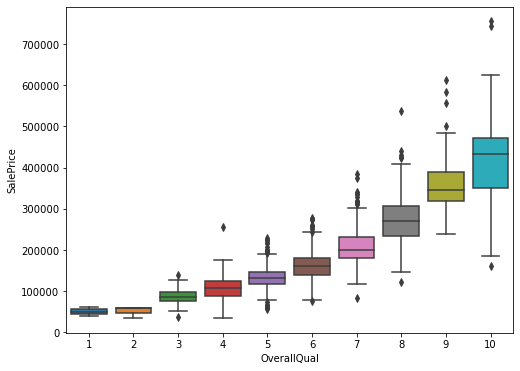

In [104]:
analysis.plot('quality')

In [ ]:
analysis.eda()